+--------------------+-------------+--------------------+----------+------------+---------------+--------------------+-----------+-------------+
|            homename|homecontinent|         homecountry|   homelat|     homelon|travelcontinent|       travelcountry|  travellat|    travellon|
+--------------------+-------------+--------------------+----------+------------+---------------+--------------------+-----------+-------------+
|Canadian in La La...|North America|United States of ...|33.9300302|-118.2809933|  North America|United States of ...| 33.8872549| -118.4119125|
|Canadian in La La...|North America|United States of ...|33.9300302|-118.2809933|  North America|United States of ...|    34.0221|     -118.481|
|Canadian in La La...|North America|United States of ...|33.9300302|-118.2809933|  North America|United States of ...|    34.0304|     -118.779|
|Canadian in La La...|North America|United States of ...|33.9300302|-118.2809933|  North America|United States of ...| 33.8872549|

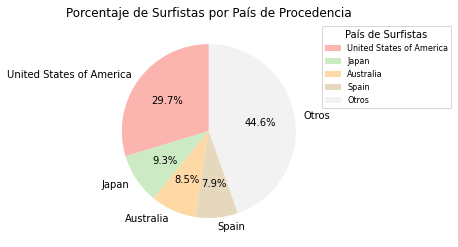

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt

# Iniciar Spark Session
spark = SparkSession.builder.appName("Surfistas").getOrCreate()

# Cargar el archivo CSV
df = spark.read.option("header", "true").csv('/FileStore/tables/viajes_surfistas.csv', inferSchema=True)

# Ver las primeras filas
df.show(5)

# Analizar cuantos países únicos tenemos
df.select('homecountry').distinct().show()

# Obtener el número de países únicos
num_paises = df.select('homecountry').distinct().count()
print(f'Número de países únicos: {num_paises}')

# Agrupar por país y contar los surfistas
agrupado = df.groupBy('homecountry').agg({'homename': 'count'}).withColumnRenamed('count(homename)', 'homename')

# Mostrar el DataFrame agrupado
agrupado.show()

# Ordenar el DataFrame por el número de surfistas
agrupado_ordenado = agrupado.orderBy('homename', ascending=False)

# Mostrar los países ordenados
agrupado_ordenado.show()

# Top 4 países
df_top_4 = agrupado_ordenado.limit(4)

# Mostrar el top 4
df_top_4.show()

# Filtrar el DataFrame original para los países que no están en el top 4
top_4_paises = [row['homecountry'] for row in df_top_4.collect()]
df_otros = agrupado_ordenado.filter(~col('homecountry').isin(top_4_paises))

# Crear una columna 'pais' con valor constante 'Otros'
df_otros = df_otros.withColumn('pais', lit('Otros'))

# Agrupar todos los demás países bajo 'Otros'
df_otros_agrupado = df_otros.groupBy('pais').agg({'homename': 'sum'}).withColumnRenamed('sum(homename)', 'homename')

# Mostrar los resultados agrupados
df_otros_agrupado.show()

# Unir el DataFrame de Top 4 con los demás países agrupados
df_otros_agrupado = df_otros_agrupado.withColumnRenamed('pais', 'homecountry')
df_final = df_top_4.union(df_otros_agrupado)

# Mostrar el DataFrame final
df_final.show()

# Convertir a Pandas para la visualización
df_final_pd = df_final.toPandas()

# Establecer el índice como 'homecountry' para facilitar la creación del gráfico de pie
df_final_pd.set_index('homecountry', inplace=True)

# Pie Chart con Pandas
ax = df_final_pd.plot.pie(
    y='homename', 
    startangle=90,
    autopct='%1.1f%%',
    colormap='Pastel1'  # Colores pastel para un gráfico agradable a la vista
)

ax.set_ylabel('')
ax.legend(
    title='País de Surfistas',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

ax.set_title('Porcentaje de Surfistas por País de Procedencia')

# Mostrar el gráfico
plt.show()


Conversión a Pandas: Aunque Spark maneja grandes volúmenes de datos de manera eficiente, para visualizaciones y gráficos como un gráfico de pie (pie chart), es necesario convertir el DataFrame a pandas, ya que PySpark no soporta directamente gráficos de este tipo.